In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import d3rlpy
import torch
import numpy as np
from matplotlib import pyplot as plt
from makeSeaquestdata import load_seaquest_dataset, make_seaquest_testset
from load_model import load_seaquest_model
from model import make_episodes, fit_discrete_sac, fit_per_cluster
from utils import create_trajectories, get_trajectory_embedding, perform_clustering_and_plot, trajectory_attributions_sq, set_seeds, print_results_sq
from encoder import CustomCNNFactory

In [3]:
# Set device and random seed
device = set_seeds(seed=0)

# Set data and test sizes
data_size, test_size = 450, 100

In [4]:
# Load Seaquest dataset
seaquestdata, sq_env = load_seaquest_dataset(env_name='Seaquest', size=data_size+test_size)

print(seaquestdata["observations"][0])
print(seaquestdata["actions"][:10])
print(seaquestdata["rewards"][:10])
print(seaquestdata["terminals"][:10])

decompressing data...
Dataset loaded
553
Dataset extracted with 992264 samples.
Information about the dataset:
Observation shape:  (992264, 4, 84, 84)
Action shape:  (992264,)
Reward shape:  (992264,)
Terminal shape:  (992264,)
Action space:  18
Observation space:  (84, 84)
Number of terminal states is... 549
Environment 'ALE/Seaquest-ram-v5' initialized.
[[[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ... 13 13 13]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ..

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
# Load pre-trained encoders
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Seaquest_123.pth", seed=0)

# Create Seaquest test set
seaquestdata, test_observation_sq = make_seaquest_testset(seaquestdata, data_size, test_size)

In [6]:
# Create trajectories and obtain embeddings for Seaquest data
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
    seaquestdata["observations"], seaquestdata["actions"], 
    seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=30
)
trajectory_embedding_seaquest = get_trajectory_embedding(
    pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
    is_seaquest=True, device=device
)

Processing sub'trajectories: 100%|██████████| 791606/791606 [00:25<00:00, 30547.81it/s]
/Users/joanvelja/miniconda3/envs/mujoco_env/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Processing trajectories:   0%|          | 0/26613 [00:00<?, ?it/s]/Users/joanvelja/miniconda3/envs/mujoco_env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Processing trajectories: 100%|██████████| 26613/26613 [04:19<00:00, 102.43it/s]


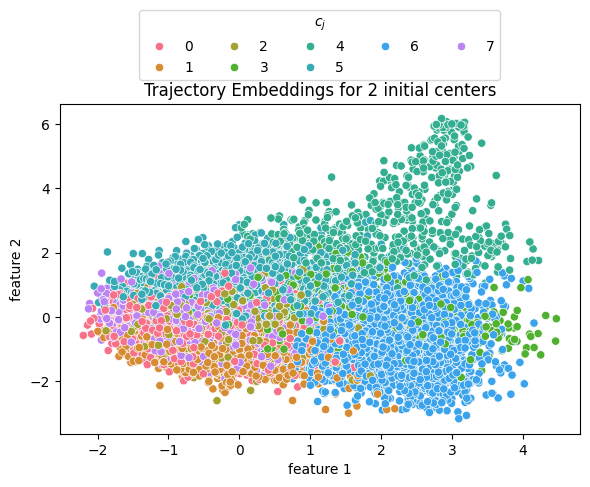

In [7]:
# Perform clustering on Seaquest data
clusters_seaquest, _ = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu().numpy(), 2, 8, ccore=True, plot=True)

In [8]:
 # Train Seaquest model with DiscreteSAC
print('#' * 100)
print("Training Seaquest with DiscreteSAC...")
list_episodes_sq = make_episodes(final_obs_sq, final_act_sq, final_rew_sq, 18)
print(list_episodes_sq[0])
sac_sq = fit_discrete_sac(list_episodes_sq, n_steps=2000, n_steps_per_epoch=200, device=device)

####################################################################################################
Training Seaquest with DiscreteSAC...
2024-04-22 23:51.32 [debug    ] RandomIterator is selected.
2024-04-22 23:51.32 [info     ] Directory is created at d3rlpy_logs/DiscreteSAC_20240422235132
2024-04-22 23:51.32 [debug    ] Fitting scaler...              scaler=pixel
2024-04-22 23:51.32 [debug    ] Building models...
2024-04-22 23:51.32 [debug    ] Models have been built.
2024-04-22 23:51.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {

Epoch 1/10: 100%|██████████| 200/200 [06:33<00:00,  1.97s/it, temp_loss=0.0511, temp=0.974, critic_loss=0.674, actor_loss=-5.28]

2024-04-22 23:58.05 [info     ] DiscreteSAC_20240422235132: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00725162148475647, 'time_algorithm_update': 1.9579951858520508, 'temp_loss': 0.05122107773786411, 'temp': 0.9725030168890954, 'critic_loss': 0.6538532276079059, 'actor_loss': -5.282883096933364, 'time_step': 1.9653431689739227} step=200
2024-04-22 23:58.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_200.pt



Epoch 2/10: 100%|██████████| 200/200 [06:21<00:00,  1.91s/it, temp_loss=0.0523, temp=0.917, critic_loss=0.215, actor_loss=-5.29]

2024-04-23 00:04.27 [info     ] DiscreteSAC_20240422235132: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.0076558530330657956, 'time_algorithm_update': 1.9000071132183074, 'temp_loss': 0.052228888254612686, 'temp': 0.9160767650604248, 'critic_loss': 0.21314472183585167, 'actor_loss': -5.279064745903015, 'time_step': 1.9077451074123382} step=400
2024-04-23 00:04.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_400.pt



Epoch 3/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0492, temp=0.866, critic_loss=0.204, actor_loss=-4.99]

2024-04-23 00:10.47 [info     ] DiscreteSAC_20240422235132: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.006963449716567993, 'time_algorithm_update': 1.8903311121463775, 'temp_loss': 0.04915980357676744, 'temp': 0.8647579237818718, 'critic_loss': 0.20449612379074097, 'actor_loss': -4.986238648891449, 'time_step': 1.8973727786540986} step=600
2024-04-23 00:10.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_600.pt



Epoch 4/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0464, temp=0.819, critic_loss=0.19, actor_loss=-4.72] 

2024-04-23 00:17.06 [info     ] DiscreteSAC_20240422235132: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.006886551380157471, 'time_algorithm_update': 1.8914679491519928, 'temp_loss': 0.0463803044706583, 'temp': 0.8177846109867096, 'critic_loss': 0.1900376494601369, 'actor_loss': -4.7167016124725345, 'time_step': 1.8984347534179689} step=800
2024-04-23 00:17.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_800.pt



Epoch 5/10: 100%|██████████| 200/200 [06:20<00:00,  1.90s/it, temp_loss=0.0439, temp=0.775, critic_loss=0.188, actor_loss=-4.47]

2024-04-23 00:23.27 [info     ] DiscreteSAC_20240422235132: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.007524857521057129, 'time_algorithm_update': 1.8927676558494568, 'temp_loss': 0.04389942141249776, 'temp': 0.7744900465011597, 'critic_loss': 0.1880101266130805, 'actor_loss': -4.469206306934357, 'time_step': 1.9003744292259217} step=1000
2024-04-23 00:23.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_1000.pt



Epoch 6/10: 100%|██████████| 200/200 [06:21<00:00,  1.91s/it, temp_loss=0.0417, temp=0.735, critic_loss=0.177, actor_loss=-4.24]

2024-04-23 00:29.48 [info     ] DiscreteSAC_20240422235132: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.0070303046703338624, 'time_algorithm_update': 1.8999011623859405, 'temp_loss': 0.04164000194519758, 'temp': 0.7342888110876084, 'critic_loss': 0.17587878536432983, 'actor_loss': -4.239517705440521, 'time_step': 1.9070123088359834} step=1200
2024-04-23 00:29.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_1200.pt



Epoch 7/10: 100%|██████████| 200/200 [06:21<00:00,  1.91s/it, temp_loss=0.0395, temp=0.698, critic_loss=0.168, actor_loss=-4.03]

2024-04-23 00:36.09 [info     ] DiscreteSAC_20240422235132: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.006977925300598145, 'time_algorithm_update': 1.8978263449668884, 'temp_loss': 0.03941730199381709, 'temp': 0.6969142240285874, 'critic_loss': 0.16865513600409032, 'actor_loss': -4.0234043300151825, 'time_step': 1.9048854541778564} step=1400
2024-04-23 00:36.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_1400.pt



Epoch 8/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0375, temp=0.663, critic_loss=0.16, actor_loss=-3.83] 

2024-04-23 00:42.29 [info     ] DiscreteSAC_20240422235132: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.007435110807418824, 'time_algorithm_update': 1.8911593675613403, 'temp_loss': 0.037411653604358434, 'temp': 0.662078812122345, 'critic_loss': 0.1602356566488743, 'actor_loss': -3.8218221509456636, 'time_step': 1.8986750221252442} step=1600
2024-04-23 00:42.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_1600.pt



Epoch 9/10: 100%|██████████| 200/200 [06:20<00:00,  1.90s/it, temp_loss=0.0355, temp=0.63, critic_loss=0.156, actor_loss=-3.64] 

2024-04-23 00:48.49 [info     ] DiscreteSAC_20240422235132: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.007387205362319947, 'time_algorithm_update': 1.8933364295959472, 'temp_loss': 0.03551705272868275, 'temp': 0.6294709831476212, 'critic_loss': 0.15655133802443744, 'actor_loss': -3.6359388625621794, 'time_step': 1.9008028781414033} step=1800
2024-04-23 00:48.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_1800.pt



Epoch 10/10: 100%|██████████| 200/200 [06:20<00:00,  1.90s/it, temp_loss=0.0337, temp=0.6, critic_loss=0.151, actor_loss=-3.47]  

2024-04-23 00:55.10 [info     ] DiscreteSAC_20240422235132: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.007162306308746338, 'time_algorithm_update': 1.8927302992343902, 'temp_loss': 0.03371142828837037, 'temp': 0.5989243146777153, 'critic_loss': 0.15067708164453505, 'actor_loss': -3.463610671758652, 'time_step': 1.8999701309204102} step=2000
2024-04-23 00:55.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240422235132/model_2000.pt


In [9]:
# Compute all possible permutations of clusters
feature_size = 128
custom_encoder_actor = CustomCNNFactory(feature_size)
custom_encoder_critic = CustomCNNFactory(feature_size)

model_params_sq = {
    'actor_learning_rate': 3e-4,
    'critic_learning_rate': 3e-4,
    'temp_learning_rate': 3e-4,
    'batch_size': 256,
    'actor_encoder_factory': custom_encoder_actor,
    'critic_encoder_factory': custom_encoder_critic,
    'scaler': 'pixel',
    'use_gpu': True if device == 'cuda' else False
}

In [10]:
# Fit models per cluster for Seaquest data
models_sq, result_data_combinations_sq = fit_per_cluster(
    model=sac_sq, 
    model_class=d3rlpy.algos.DiscreteSAC,
    model_params=model_params_sq,
    data_embedding=trajectory_embedding_seaquest,
    list_episodes=list_episodes_sq,
    clusters=clusters_seaquest,
    trajectory_embedding=trajectory_embedding_seaquest,
    test_observations=test_observation_sq
)

Original model action:  [1]
Original model action value:  [1.9703081]
Passing:  1 1.9703081
Original model action:  [1]
Original model action value:  [1.8410177]
Passing:  1 1.8410177
Original model action:  [1]
Original model action value:  [1.9176083]
Passing:  1 1.9176083
Original model action:  [1]
Original model action value:  [1.7959815]
Passing:  1 1.7959815
Original model action:  [1]
Original model action value:  [1.9288137]
Passing:  1 1.9288137
Original model action:  [1]
Original model action value:  [1.9205229]
Passing:  1 1.9205229
Original model action:  [1]
Original model action value:  [1.8449275]
Passing:  1 1.8449275
Original model action:  [1]
Original model action value:  [1.8957127]
Passing:  1 1.8957127
Original model action:  [1]
Original model action value:  [1.9703081]
Passing:  1 1.9703081
Original model action:  [1]
Original model action value:  [2.0812302]
Passing:  1 2.0812302
Original model action:  [1]
Original model action value:  [1.7922436]
Passing:  

Epoch 1/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0492, temp=0.977, critic_loss=0.659, actor_loss=-5.3] 

2024-04-23 01:01.40 [info     ] DiscreteSAC_20240423005521: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.006529773473739624, 'time_algorithm_update': 1.8873075878620147, 'temp_loss': 0.04943247663090006, 'temp': 0.9755517882108689, 'critic_loss': 0.6398436439037323, 'actor_loss': -5.305457625389099, 'time_step': 1.893917169570923} step=200
2024-04-23 01:01.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_200.pt



Epoch 2/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0525, temp=0.922, critic_loss=0.208, actor_loss=-5.31]

2024-04-23 01:07.58 [info     ] DiscreteSAC_20240423005521: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.006802464723587036, 'time_algorithm_update': 1.886015523672104, 'temp_loss': 0.0524777183867991, 'temp': 0.9209115013480187, 'critic_loss': 0.20787071965634824, 'actor_loss': -5.2984517121315005, 'time_step': 1.8929051840305329} step=400
2024-04-23 01:07.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_400.pt



Epoch 3/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0496, temp=0.871, critic_loss=0.206, actor_loss=-5.01]

2024-04-23 01:14.18 [info     ] DiscreteSAC_20240423005521: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.006763402223587036, 'time_algorithm_update': 1.8883229529857635, 'temp_loss': 0.04950101014226675, 'temp': 0.8698028740286827, 'critic_loss': 0.2058101938292384, 'actor_loss': -5.004384214878082, 'time_step': 1.8951705014705658} step=600
2024-04-23 01:14.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_600.pt



Epoch 4/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0469, temp=0.824, critic_loss=0.198, actor_loss=-4.74]

2024-04-23 01:20.37 [info     ] DiscreteSAC_20240423005521: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.0074985122680664065, 'time_algorithm_update': 1.887189178466797, 'temp_loss': 0.046788174491375685, 'temp': 0.8227754232287406, 'critic_loss': 0.1985358975827694, 'actor_loss': -4.731957437992096, 'time_step': 1.8947705483436585} step=800
2024-04-23 01:20.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_800.pt



Epoch 5/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0443, temp=0.78, critic_loss=0.193, actor_loss=-4.49] 

2024-04-23 01:26.56 [info     ] DiscreteSAC_20240423005521: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.006704440116882324, 'time_algorithm_update': 1.88968940615654, 'temp_loss': 0.04429492691531777, 'temp': 0.7793392661213875, 'critic_loss': 0.1926335959136486, 'actor_loss': -4.483655099868774, 'time_step': 1.896474827528} step=1000
2024-04-23 01:26.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_1000.pt



Epoch 6/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0419, temp=0.74, critic_loss=0.18, actor_loss=-4.25]  

2024-04-23 01:33.16 [info     ] DiscreteSAC_20240423005521: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.0072273540496826175, 'time_algorithm_update': 1.8902086162567138, 'temp_loss': 0.04186554627493024, 'temp': 0.7389871299266815, 'critic_loss': 0.17966578360646962, 'actor_loss': -4.2483389592170715, 'time_step': 1.8975184440612793} step=1200
2024-04-23 01:33.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_1200.pt



Epoch 7/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0399, temp=0.702, critic_loss=0.166, actor_loss=-4.04]

2024-04-23 01:39.35 [info     ] DiscreteSAC_20240423005521: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.006721391677856446, 'time_algorithm_update': 1.8884518003463746, 'temp_loss': 0.03985251994803548, 'temp': 0.701439138352871, 'critic_loss': 0.16510788455605507, 'actor_loss': -4.034358297586441, 'time_step': 1.8952508926391602} step=1400
2024-04-23 01:39.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_1400.pt



Epoch 8/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0377, temp=0.667, critic_loss=0.163, actor_loss=-3.84]

2024-04-23 01:45.54 [info     ] DiscreteSAC_20240423005521: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.006393338441848755, 'time_algorithm_update': 1.8883911967277527, 'temp_loss': 0.03769332017749548, 'temp': 0.6664012840390205, 'critic_loss': 0.1622124892473221, 'actor_loss': -3.834840601682663, 'time_step': 1.8948623466491699} step=1600
2024-04-23 01:45.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_1600.pt



Epoch 9/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0357, temp=0.634, critic_loss=0.154, actor_loss=-3.65]

2024-04-23 01:52.13 [info     ] DiscreteSAC_20240423005521: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.006189392805099487, 'time_algorithm_update': 1.8890471923351289, 'temp_loss': 0.035721156056970356, 'temp': 0.6336890631914138, 'critic_loss': 0.15415279898792505, 'actor_loss': -3.648507912158966, 'time_step': 1.8953163695335389} step=1800
2024-04-23 01:52.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_1800.pt



Epoch 10/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0342, temp=0.604, critic_loss=0.147, actor_loss=-3.48]

2024-04-23 01:58.32 [info     ] DiscreteSAC_20240423005521: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.006014502048492432, 'time_algorithm_update': 1.885476943254471, 'temp_loss': 0.034165023900568484, 'temp': 0.6029238149523735, 'critic_loss': 0.14702664270997048, 'actor_loss': -3.4758184123039246, 'time_step': 1.8915701174736024} step=2000
2024-04-23 01:58.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423005521/model_2000.pt


New model action:  [1]
New model action value:  [1.9410151]
Passing:  1 1.9410151
New model action:  [1]
New model action value:  [1.8165617]
Passing:  1 1.8165617
New model action:  [1]
New model action value:  [1.8341602]
Passing:  1 1.8341602
New model action:  [1]
New model action value:  [1.7698251]
Passing:  1 1.7698251
New model action:  [1]
New model action value:  [1.8852763]
Passing:  1 1.8852763
New model action:  [1]
New model action value:  [1.8780707]
Passing:  1 1.8780707
New model action:  [1]
New model action value:  [1.7950323]
Passing:  1 1.7950323
New model action:  [1]
New model action value:  [1.8508759]
Passing:  1 1.8508759
New model action:  [1]
New model action value:  [1.9410151]
Passing:  1 1.9410151
New model action:  [1]
New model action value:  [1.9948211]
Passing:  1 1.9948211
New model action:  [1]
New model action value:  [1.7574906]
Passing:  1 1.7574906
New model action:  [1]
New model action value:  [1.9323283]
Passing:  1 1.9323283
New model action

Epoch 1/10: 100%|██████████| 200/200 [06:17<00:00,  1.89s/it, temp_loss=0.0495, temp=0.975, critic_loss=0.631, actor_loss=-5.3] 

2024-04-23 02:04.54 [info     ] DiscreteSAC_20240423015836: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.006043540239334106, 'time_algorithm_update': 1.8825256252288818, 'temp_loss': 0.049731949237175284, 'temp': 0.9737148568034172, 'critic_loss': 0.6124343314766884, 'actor_loss': -5.302015202045441, 'time_step': 1.8886496329307556} step=200
2024-04-23 02:04.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_200.pt



Epoch 2/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0524, temp=0.918, critic_loss=0.211, actor_loss=-5.28]

2024-04-23 02:11.12 [info     ] DiscreteSAC_20240423015836: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.006493749618530273, 'time_algorithm_update': 1.883835542201996, 'temp_loss': 0.05231843521818519, 'temp': 0.9170611876249314, 'critic_loss': 0.21189337741583586, 'actor_loss': -5.268443264961243, 'time_step': 1.8904096353054047} step=400
2024-04-23 02:11.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_400.pt



Epoch 3/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0494, temp=0.867, critic_loss=0.204, actor_loss=-4.98]

2024-04-23 02:17.30 [info     ] DiscreteSAC_20240423015836: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.006510040760040283, 'time_algorithm_update': 1.8842492830753326, 'temp_loss': 0.04930593216791749, 'temp': 0.8655301079154014, 'critic_loss': 0.2036112132295966, 'actor_loss': -4.972396321296692, 'time_step': 1.89084632396698} step=600
2024-04-23 02:17.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_600.pt



Epoch 4/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0466, temp=0.819, critic_loss=0.196, actor_loss=-4.72]

2024-04-23 02:23.49 [info     ] DiscreteSAC_20240423015836: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.006419227123260498, 'time_algorithm_update': 1.8875964570045471, 'temp_loss': 0.04658340910449624, 'temp': 0.8183997431397438, 'critic_loss': 0.19425402075052262, 'actor_loss': -4.710996537208557, 'time_step': 1.8940927839279176} step=800
2024-04-23 02:23.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_800.pt



Epoch 5/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0442, temp=0.776, critic_loss=0.185, actor_loss=-4.47]

2024-04-23 02:30.08 [info     ] DiscreteSAC_20240423015836: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.0062651681900024415, 'time_algorithm_update': 1.886033948659897, 'temp_loss': 0.04413976363837719, 'temp': 0.7748945221304894, 'critic_loss': 0.18474244199693202, 'actor_loss': -4.462658650875092, 'time_step': 1.8923787069320679} step=1000
2024-04-23 02:30.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_1000.pt



Epoch 6/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0418, temp=0.736, critic_loss=0.174, actor_loss=-4.24]

2024-04-23 02:36.27 [info     ] DiscreteSAC_20240423015836: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.005982458591461182, 'time_algorithm_update': 1.8866220033168792, 'temp_loss': 0.041723957564681766, 'temp': 0.7346398344635964, 'critic_loss': 0.1738406828790903, 'actor_loss': -4.236444075107574, 'time_step': 1.8926824593544007} step=1200
2024-04-23 02:36.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_1200.pt



Epoch 7/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0395, temp=0.698, critic_loss=0.168, actor_loss=-4.02]

2024-04-23 02:42.46 [info     ] DiscreteSAC_20240423015836: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.006455867290496826, 'time_algorithm_update': 1.890603482723236, 'temp_loss': 0.03947886189445853, 'temp': 0.6972846934199333, 'critic_loss': 0.16855225965380669, 'actor_loss': -4.017557759284973, 'time_step': 1.8971421754360198} step=1400
2024-04-23 02:42.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_1400.pt



Epoch 8/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0376, temp=0.663, critic_loss=0.164, actor_loss=-3.82]

2024-04-23 02:49.05 [info     ] DiscreteSAC_20240423015836: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.00634467363357544, 'time_algorithm_update': 1.8864263236522674, 'temp_loss': 0.03753691490739584, 'temp': 0.6624097865819931, 'critic_loss': 0.16415112022310496, 'actor_loss': -3.8202102065086363, 'time_step': 1.8928524577617645} step=1600
2024-04-23 02:49.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_1600.pt



Epoch 9/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0358, temp=0.63, critic_loss=0.151, actor_loss=-3.64] 

2024-04-23 02:55.23 [info     ] DiscreteSAC_20240423015836: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.00596577525138855, 'time_algorithm_update': 1.884228481054306, 'temp_loss': 0.03574753103777766, 'temp': 0.6297139614820481, 'critic_loss': 0.1512158739566803, 'actor_loss': -3.632004417181015, 'time_step': 1.8902719247341155} step=1800
2024-04-23 02:55.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_1800.pt



Epoch 10/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0338, temp=0.6, critic_loss=0.148, actor_loss=-3.46]  

2024-04-23 03:01.42 [info     ] DiscreteSAC_20240423015836: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.006383336782455444, 'time_algorithm_update': 1.8851861727237702, 'temp_loss': 0.03380745425820351, 'temp': 0.5991485834121704, 'critic_loss': 0.14770753882825374, 'actor_loss': -3.459676181077957, 'time_step': 1.8916495716571808} step=2000
2024-04-23 03:01.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423015836/model_2000.pt


New model action:  [1]
New model action value:  [2.0071113]
Passing:  1 2.0071113
New model action:  [1]
New model action value:  [1.8714612]
Passing:  1 1.8714612
New model action:  [1]
New model action value:  [1.9144058]
Passing:  1 1.9144058
New model action:  [1]
New model action value:  [1.7939551]
Passing:  1 1.7939551
New model action:  [1]
New model action value:  [1.9457564]
Passing:  1 1.9457564
New model action:  [1]
New model action value:  [1.9199878]
Passing:  1 1.9199878
New model action:  [1]
New model action value:  [1.8550361]
Passing:  1 1.8550361
New model action:  [1]
New model action value:  [1.8911172]
Passing:  1 1.8911172
New model action:  [1]
New model action value:  [2.0071113]
Passing:  1 2.0071113
New model action:  [1]
New model action value:  [2.0056987]
Passing:  1 2.0056987
New model action:  [1]
New model action value:  [1.801501]
Passing:  1 1.801501
New model action:  [1]
New model action value:  [1.987508]
Passing:  1 1.987508
New model action:  [

Epoch 1/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0533, temp=0.972, critic_loss=0.616, actor_loss=-5.28]

2024-04-23 03:08.04 [info     ] DiscreteSAC_20240423030146: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.0060879790782928465, 'time_algorithm_update': 1.885847532749176, 'temp_loss': 0.05328788380138576, 'temp': 0.9704881528019905, 'critic_loss': 0.598875348828733, 'actor_loss': -5.2833436536788945, 'time_step': 1.8920121967792511} step=200
2024-04-23 03:08.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_200.pt



Epoch 2/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0523, temp=0.915, critic_loss=0.21, actor_loss=-5.26] 

2024-04-23 03:14.23 [info     ] DiscreteSAC_20240423030146: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.006257383823394775, 'time_algorithm_update': 1.887580568790436, 'temp_loss': 0.0522057555988431, 'temp': 0.9138718795776367, 'critic_loss': 0.20993062023073436, 'actor_loss': -5.248771007061005, 'time_step': 1.8939152991771697} step=400
2024-04-23 03:14.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_400.pt



Epoch 3/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0491, temp=0.864, critic_loss=0.206, actor_loss=-4.96]

2024-04-23 03:20.43 [info     ] DiscreteSAC_20240423030146: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.006520596742630005, 'time_algorithm_update': 1.8928592920303344, 'temp_loss': 0.04906105617061257, 'temp': 0.8627006849646568, 'critic_loss': 0.20731984443962573, 'actor_loss': -4.955235302448273, 'time_step': 1.899461989402771} step=600
2024-04-23 03:20.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_600.pt



Epoch 4/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0464, temp=0.817, critic_loss=0.194, actor_loss=-4.7] 

2024-04-23 03:27.02 [info     ] DiscreteSAC_20240423030146: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.0061287546157836915, 'time_algorithm_update': 1.8879364812374115, 'temp_loss': 0.04636314852163195, 'temp': 0.8159422582387924, 'critic_loss': 0.1941807946935296, 'actor_loss': -4.688779928684235, 'time_step': 1.8941424131393432} step=800
2024-04-23 03:27.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_800.pt



Epoch 5/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.044, temp=0.774, critic_loss=0.184, actor_loss=-4.44] 

2024-04-23 03:33.21 [info     ] DiscreteSAC_20240423030146: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.005947331190109253, 'time_algorithm_update': 1.8866651964187622, 'temp_loss': 0.04392791965976357, 'temp': 0.7727019426226616, 'critic_loss': 0.1834600469097495, 'actor_loss': -4.43906489610672, 'time_step': 1.8926898002624513} step=1000
2024-04-23 03:33.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_1000.pt



Epoch 6/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0417, temp=0.733, critic_loss=0.174, actor_loss=-4.21]

2024-04-23 03:39.40 [info     ] DiscreteSAC_20240423030146: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.006084612607955933, 'time_algorithm_update': 1.8892506599426269, 'temp_loss': 0.04168538784608245, 'temp': 0.7325479489564896, 'critic_loss': 0.17428936064243317, 'actor_loss': -4.2090387272834775, 'time_step': 1.8954139316082002} step=1200
2024-04-23 03:39.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_1200.pt



Epoch 7/10: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it, temp_loss=0.0395, temp=0.696, critic_loss=0.171, actor_loss=-4]   

2024-04-23 03:46.00 [info     ] DiscreteSAC_20240423030146: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.00645053505897522, 'time_algorithm_update': 1.888717259168625, 'temp_loss': 0.03939652079716325, 'temp': 0.6952335298061371, 'critic_loss': 0.1703358833119273, 'actor_loss': -3.9936199128627776, 'time_step': 1.8952487289905549} step=1400
2024-04-23 03:46.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_1400.pt



Epoch 8/10: 100%|██████████| 200/200 [06:20<00:00,  1.90s/it, temp_loss=0.0374, temp=0.661, critic_loss=0.159, actor_loss=-3.81]

2024-04-23 03:52.20 [info     ] DiscreteSAC_20240423030146: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.006614458560943603, 'time_algorithm_update': 1.8961726903915406, 'temp_loss': 0.03733881114050746, 'temp': 0.6605571141839027, 'critic_loss': 0.15931740179657936, 'actor_loss': -3.8008313632011412, 'time_step': 1.9028679645061493} step=1600
2024-04-23 03:52.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_1600.pt



Epoch 9/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0356, temp=0.629, critic_loss=0.154, actor_loss=-3.62]

2024-04-23 03:58.39 [info     ] DiscreteSAC_20240423030146: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.006238738298416138, 'time_algorithm_update': 1.8844021344184876, 'temp_loss': 0.03554432779550552, 'temp': 0.6280154034495353, 'critic_loss': 0.15456987623125315, 'actor_loss': -3.6127051949501037, 'time_step': 1.8907222747802734} step=1800
2024-04-23 03:58.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_1800.pt



Epoch 10/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0339, temp=0.598, critic_loss=0.147, actor_loss=-3.44]

2024-04-23 04:04.57 [info     ] DiscreteSAC_20240423030146: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.006341538429260254, 'time_algorithm_update': 1.8849662804603577, 'temp_loss': 0.03385070748627186, 'temp': 0.5974885356426239, 'critic_loss': 0.14591993063688277, 'actor_loss': -3.4394409370422365, 'time_step': 1.8913859045505523} step=2000
2024-04-23 04:04.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423030146/model_2000.pt


New model action:  [1]
New model action value:  [1.9632993]
Passing:  1 1.9632993
New model action:  [1]
New model action value:  [1.846978]
Passing:  1 1.846978
New model action:  [1]
New model action value:  [1.8959975]
Passing:  1 1.8959975
New model action:  [1]
New model action value:  [1.8031914]
Passing:  1 1.8031914
New model action:  [1]
New model action value:  [1.9241822]
Passing:  1 1.9241822
New model action:  [1]
New model action value:  [1.8880847]
Passing:  1 1.8880847
New model action:  [1]
New model action value:  [1.8124881]
Passing:  1 1.8124881
New model action:  [1]
New model action value:  [1.8829861]
Passing:  1 1.8829861
New model action:  [1]
New model action value:  [1.9632993]
Passing:  1 1.9632993
New model action:  [1]
New model action value:  [2.0227823]
Passing:  1 2.0227823
New model action:  [1]
New model action value:  [1.7744853]
Passing:  1 1.7744853
New model action:  [1]
New model action value:  [1.9800346]
Passing:  1 1.9800346
New model action: 

Epoch 1/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0453, temp=0.982, critic_loss=0.659, actor_loss=-5.32]

2024-04-23 04:11.19 [info     ] DiscreteSAC_20240423040501: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.006204220056533813, 'time_algorithm_update': 1.8842379832267762, 'temp_loss': 0.045702653359621766, 'temp': 0.9805583828687667, 'critic_loss': 0.6397810960561037, 'actor_loss': -5.331311616897583, 'time_step': 1.8905214035511018} step=200
2024-04-23 04:11.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_200.pt



Epoch 2/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0524, temp=0.931, critic_loss=0.216, actor_loss=-5.36]

2024-04-23 04:17.38 [info     ] DiscreteSAC_20240423040501: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.006836988925933838, 'time_algorithm_update': 1.8866841387748718, 'temp_loss': 0.05233541136607528, 'temp': 0.9297639507055283, 'critic_loss': 0.21599975768476726, 'actor_loss': -5.350649499893189, 'time_step': 1.893603492975235} step=400
2024-04-23 04:17.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_400.pt



Epoch 3/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0496, temp=0.881, critic_loss=0.212, actor_loss=-5.07]

2024-04-23 04:23.56 [info     ] DiscreteSAC_20240423040501: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.006334483623504639, 'time_algorithm_update': 1.8832678520679473, 'temp_loss': 0.04960579754784703, 'temp': 0.8798593008518218, 'critic_loss': 0.20981934383511544, 'actor_loss': -5.065437965393066, 'time_step': 1.8896832883358001} step=600
2024-04-23 04:23.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_600.pt



Epoch 4/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.047, temp=0.834, critic_loss=0.198, actor_loss=-4.8]  

2024-04-23 04:30.14 [info     ] DiscreteSAC_20240423040501: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.006250356435775757, 'time_algorithm_update': 1.883873301744461, 'temp_loss': 0.04691424889490008, 'temp': 0.8331654649972916, 'critic_loss': 0.19702392656356096, 'actor_loss': -4.796798875331879, 'time_step': 1.8902018213272094} step=800
2024-04-23 04:30.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_800.pt



Epoch 5/10: 100%|██████████| 200/200 [06:17<00:00,  1.89s/it, temp_loss=0.0447, temp=0.791, critic_loss=0.191, actor_loss=-4.55]

2024-04-23 04:36.32 [info     ] DiscreteSAC_20240423040501: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.006177823543548584, 'time_algorithm_update': 1.8832541978359223, 'temp_loss': 0.04460768587887287, 'temp': 0.7895686620473862, 'critic_loss': 0.19030630212277175, 'actor_loss': -4.541824579238892, 'time_step': 1.8895118129253388} step=1000
2024-04-23 04:36.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_1000.pt



Epoch 6/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0421, temp=0.75, critic_loss=0.175, actor_loss=-4.32] 

2024-04-23 04:42.51 [info     ] DiscreteSAC_20240423040501: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.0065468263626098635, 'time_algorithm_update': 1.8838852202892304, 'temp_loss': 0.042100672740489245, 'temp': 0.7489333170652389, 'critic_loss': 0.17455769393593074, 'actor_loss': -4.318769507408142, 'time_step': 1.8905135989189148} step=1200
2024-04-23 04:42.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_1200.pt



Epoch 7/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0401, temp=0.712, critic_loss=0.17, actor_loss=-4.11] 

2024-04-23 04:49.09 [info     ] DiscreteSAC_20240423040501: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.00648931622505188, 'time_algorithm_update': 1.8831762623786927, 'temp_loss': 0.040042174346745014, 'temp': 0.7111007949709892, 'critic_loss': 0.17026777505874635, 'actor_loss': -4.1013593053817745, 'time_step': 1.88974693775177} step=1400
2024-04-23 04:49.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_1400.pt



Epoch 8/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0379, temp=0.676, critic_loss=0.165, actor_loss=-3.9] 

2024-04-23 04:55.27 [info     ] DiscreteSAC_20240423040501: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.006157296895980835, 'time_algorithm_update': 1.8856508886814118, 'temp_loss': 0.03783856378868222, 'temp': 0.6757287022471428, 'critic_loss': 0.16326368771493435, 'actor_loss': -3.8972318041324616, 'time_step': 1.8918857872486115} step=1600
2024-04-23 04:55.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_1600.pt



Epoch 9/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.036, temp=0.643, critic_loss=0.154, actor_loss=-3.72] 

2024-04-23 05:01.46 [info     ] DiscreteSAC_20240423040501: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.006200634241104126, 'time_algorithm_update': 1.8881837487220765, 'temp_loss': 0.035879288502037525, 'temp': 0.6427564108371735, 'critic_loss': 0.1543782127276063, 'actor_loss': -3.712615267038345, 'time_step': 1.8944666063785554} step=1800
2024-04-23 05:01.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_1800.pt



Epoch 10/10: 100%|██████████| 200/200 [06:17<00:00,  1.89s/it, temp_loss=0.0338, temp=0.613, critic_loss=0.153, actor_loss=-3.54]

2024-04-23 05:08.04 [info     ] DiscreteSAC_20240423040501: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.006441398859024048, 'time_algorithm_update': 1.882923847436905, 'temp_loss': 0.03373972112312913, 'temp': 0.6119264006614685, 'critic_loss': 0.15314018949866295, 'actor_loss': -3.5328341615200043, 'time_step': 1.8894454884529113} step=2000
2024-04-23 05:08.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423040501/model_2000.pt


New model action:  [1]
New model action value:  [2.0038118]
Passing:  1 2.0038118
New model action:  [1]
New model action value:  [1.8634756]
Passing:  1 1.8634756
New model action:  [1]
New model action value:  [1.9148676]
Passing:  1 1.9148676
New model action:  [1]
New model action value:  [1.7547605]
Passing:  1 1.7547605
New model action:  [1]
New model action value:  [1.9466138]
Passing:  1 1.9466138
New model action:  [1]
New model action value:  [1.8880315]
Passing:  1 1.8880315
New model action:  [1]
New model action value:  [1.8240957]
Passing:  1 1.8240957
New model action:  [1]
New model action value:  [1.8535571]
Passing:  1 1.8535571
New model action:  [1]
New model action value:  [2.0038118]
Passing:  1 2.0038118
New model action:  [1]
New model action value:  [2.0287623]
Passing:  1 2.0287623
New model action:  [1]
New model action value:  [1.7791973]
Passing:  1 1.7791973
New model action:  [1]
New model action value:  [1.982752]
Passing:  1 1.982752
New model action: 

Epoch 1/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.052, temp=0.973, critic_loss=0.631, actor_loss=-5.33] 

2024-04-23 05:14.27 [info     ] DiscreteSAC_20240423050808: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.0064957523345947265, 'time_algorithm_update': 1.8869193816184997, 'temp_loss': 0.05210122447810136, 'temp': 0.9716962105035782, 'critic_loss': 0.6125686111301184, 'actor_loss': -5.335642689466477, 'time_step': 1.8934952557086944} step=200
2024-04-23 05:14.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_200.pt



Epoch 2/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0522, temp=0.916, critic_loss=0.22, actor_loss=-5.28] 

2024-04-23 05:20.46 [info     ] DiscreteSAC_20240423050808: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.006589711904525757, 'time_algorithm_update': 1.8861439442634582, 'temp_loss': 0.052081609405577184, 'temp': 0.9152517405152321, 'critic_loss': 0.2196248373016715, 'actor_loss': -5.274516184329986, 'time_step': 1.8928148102760316} step=400
2024-04-23 05:20.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_400.pt



Epoch 3/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.049, temp=0.865, critic_loss=0.203, actor_loss=-4.99] 

2024-04-23 05:27.04 [info     ] DiscreteSAC_20240423050808: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.006437662839889526, 'time_algorithm_update': 1.8835673177242278, 'temp_loss': 0.0489529937505722, 'temp': 0.8640974521636963, 'critic_loss': 0.20316041976213456, 'actor_loss': -4.980438976287842, 'time_step': 1.8900843262672424} step=600
2024-04-23 05:27.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_600.pt



Epoch 4/10: 100%|██████████| 200/200 [06:16<00:00,  1.88s/it, temp_loss=0.0464, temp=0.818, critic_loss=0.197, actor_loss=-4.71]

2024-04-23 05:33.21 [info     ] DiscreteSAC_20240423050808: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.006499794721603394, 'time_algorithm_update': 1.876759147644043, 'temp_loss': 0.046310612596571446, 'temp': 0.8171919187903405, 'critic_loss': 0.1982171920314431, 'actor_loss': -4.708858389854431, 'time_step': 1.8833405601978301} step=800
2024-04-23 05:33.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_800.pt



Epoch 5/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0438, temp=0.775, critic_loss=0.192, actor_loss=-4.46]

2024-04-23 05:39.39 [info     ] DiscreteSAC_20240423050808: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.006118724346160889, 'time_algorithm_update': 1.886396083831787, 'temp_loss': 0.04373220562934876, 'temp': 0.7739109438657761, 'critic_loss': 0.19178799588233233, 'actor_loss': -4.459646053314209, 'time_step': 1.8925944876670837} step=1000
2024-04-23 05:39.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_1000.pt



Epoch 6/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0414, temp=0.735, critic_loss=0.183, actor_loss=-4.24]

2024-04-23 05:45.58 [info     ] DiscreteSAC_20240423050808: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.006389790773391723, 'time_algorithm_update': 1.8859872424602508, 'temp_loss': 0.04136656304821372, 'temp': 0.7338830265402794, 'critic_loss': 0.18255894169211387, 'actor_loss': -4.233517460823059, 'time_step': 1.8924618542194367} step=1200
2024-04-23 05:45.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_1200.pt



Epoch 7/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0393, temp=0.697, critic_loss=0.175, actor_loss=-4.03]

2024-04-23 05:52.17 [info     ] DiscreteSAC_20240423050808: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.006505750417709351, 'time_algorithm_update': 1.8857998418807984, 'temp_loss': 0.039283504337072374, 'temp': 0.6966014921665191, 'critic_loss': 0.17443466644734143, 'actor_loss': -4.025999610424042, 'time_step': 1.8923867619037629} step=1400
2024-04-23 05:52.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_1400.pt



Epoch 8/10: 100%|██████████| 200/200 [06:18<00:00,  1.89s/it, temp_loss=0.0375, temp=0.662, critic_loss=0.168, actor_loss=-3.82]

2024-04-23 05:58.35 [info     ] DiscreteSAC_20240423050808: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.006212483644485473, 'time_algorithm_update': 1.8866040563583375, 'temp_loss': 0.037430328261107204, 'temp': 0.6617094388604164, 'critic_loss': 0.16741454791277646, 'actor_loss': -3.8202377116680144, 'time_step': 1.8928956043720246} step=1600
2024-04-23 05:58.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_1600.pt



Epoch 9/10: 100%|██████████| 200/200 [06:32<00:00,  1.96s/it, temp_loss=0.0355, temp=0.63, critic_loss=0.151, actor_loss=-3.64] 

2024-04-23 06:05.08 [info     ] DiscreteSAC_20240423050808: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.013549551963806153, 'time_algorithm_update': 1.950141921043396, 'temp_loss': 0.0355094581656158, 'temp': 0.629019413292408, 'critic_loss': 0.1507752811908722, 'actor_loss': -3.637520222663879, 'time_step': 1.9637902796268463} step=1800
2024-04-23 06:05.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_1800.pt



Epoch 10/10: 100%|██████████| 200/200 [06:28<00:00,  1.94s/it, temp_loss=0.0338, temp=0.599, critic_loss=0.148, actor_loss=-3.47]

2024-04-23 06:11.37 [info     ] DiscreteSAC_20240423050808: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.010846132040023803, 'time_algorithm_update': 1.9331160020828246, 'temp_loss': 0.03373899897560477, 'temp': 0.5984233206510544, 'critic_loss': 0.14884456377476454, 'actor_loss': -3.463593726158142, 'time_step': 1.9440562045574188} step=2000
2024-04-23 06:11.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423050808/model_2000.pt


New model action:  [1]
New model action value:  [1.8061854]
Passing:  1 1.8061854
New model action:  [1]
New model action value:  [1.6889215]
Passing:  1 1.6889215
New model action:  [1]
New model action value:  [1.7194653]
Passing:  1 1.7194653
New model action:  [1]
New model action value:  [1.6306448]
Passing:  1 1.6306448
New model action:  [1]
New model action value:  [1.7472775]
Passing:  1 1.7472775
New model action:  [1]
New model action value:  [1.7389089]
Passing:  1 1.7389089
New model action:  [1]
New model action value:  [1.6783736]
Passing:  1 1.6783736
New model action:  [1]
New model action value:  [1.7140957]
Passing:  1 1.7140957
New model action:  [1]
New model action value:  [1.8061854]
Passing:  1 1.8061854
New model action:  [1]
New model action value:  [1.8331311]
Passing:  1 1.8331311
New model action:  [1]
New model action value:  [1.6368095]
Passing:  1 1.6368095
New model action:  [1]
New model action value:  [1.7953162]
Passing:  1 1.7953162
New model action

Epoch 1/10: 100%|██████████| 200/200 [06:33<00:00,  1.97s/it, temp_loss=0.0409, temp=0.985, critic_loss=0.704, actor_loss=-5.29]

2024-04-23 06:18.14 [info     ] DiscreteSAC_20240423061141: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.012071492671966553, 'time_algorithm_update': 1.9547156119346618, 'temp_loss': 0.04154360018903389, 'temp': 0.9834754076600075, 'critic_loss': 0.6814518209546805, 'actor_loss': -5.30192342042923, 'time_step': 1.9668798744678497} step=200
2024-04-23 06:18.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_200.pt



Epoch 2/10: 100%|██████████| 200/200 [06:34<00:00,  1.97s/it, temp_loss=0.0534, temp=0.936, critic_loss=0.224, actor_loss=-5.39]

2024-04-23 06:24.49 [info     ] DiscreteSAC_20240423061141: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.010859222412109374, 'time_algorithm_update': 1.9591289484500884, 'temp_loss': 0.05338396871462464, 'temp': 0.9345404553413391, 'critic_loss': 0.22302179697901012, 'actor_loss': -5.380343704223633, 'time_step': 1.9700790846347809} step=400
2024-04-23 06:24.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_400.pt



Epoch 3/10: 100%|██████████| 200/200 [06:31<00:00,  1.96s/it, temp_loss=0.0505, temp=0.886, critic_loss=0.204, actor_loss=-5.1] 

2024-04-23 06:31.20 [info     ] DiscreteSAC_20240423061141: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.011246528625488281, 'time_algorithm_update': 1.9466683304309844, 'temp_loss': 0.050408543683588505, 'temp': 0.8847067052125931, 'critic_loss': 0.2038845606520772, 'actor_loss': -5.093551995754242, 'time_step': 1.9580052554607392} step=600
2024-04-23 06:31.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_600.pt



Epoch 4/10: 100%|██████████| 200/200 [06:32<00:00,  1.96s/it, temp_loss=0.0477, temp=0.839, critic_loss=0.197, actor_loss=-4.83]

2024-04-23 06:37.53 [info     ] DiscreteSAC_20240423061141: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.011398577690124511, 'time_algorithm_update': 1.9501792752742768, 'temp_loss': 0.04765684945508838, 'temp': 0.8380954352021217, 'critic_loss': 0.1968646813184023, 'actor_loss': -4.825512530803681, 'time_step': 1.961768661737442} step=800
2024-04-23 06:37.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_800.pt



Epoch 5/10: 100%|██████████| 200/200 [06:50<00:00,  2.05s/it, temp_loss=0.0453, temp=0.795, critic_loss=0.188, actor_loss=-4.58]

2024-04-23 06:44.43 [info     ] DiscreteSAC_20240423061141: epoch=5 step=1000 epoch=5 metrics={'time_sample_batch': 0.05660016417503357, 'time_algorithm_update': 1.9944172489643097, 'temp_loss': 0.04529682682827115, 'temp': 0.7944917371869087, 'critic_loss': 0.18795522287487984, 'actor_loss': -4.5754307794570925, 'time_step': 2.0511661159992216} step=1000
2024-04-23 06:44.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_1000.pt



Epoch 6/10: 100%|██████████| 200/200 [06:48<00:00,  2.04s/it, temp_loss=0.043, temp=0.755, critic_loss=0.178, actor_loss=-4.35] 

2024-04-23 06:51.32 [info     ] DiscreteSAC_20240423061141: epoch=6 step=1200 epoch=6 metrics={'time_sample_batch': 0.05848779320716858, 'time_algorithm_update': 1.982139016389847, 'temp_loss': 0.042995116151869295, 'temp': 0.7537363404035569, 'critic_loss': 0.17832980796694756, 'actor_loss': -4.345554988384247, 'time_step': 2.040742380619049} step=1200
2024-04-23 06:51.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_1200.pt



Epoch 7/10: 100%|██████████| 200/200 [06:35<00:00,  1.98s/it, temp_loss=0.0408, temp=0.716, critic_loss=0.176, actor_loss=-4.13]

2024-04-23 06:58.07 [info     ] DiscreteSAC_20240423061141: epoch=7 step=1400 epoch=7 metrics={'time_sample_batch': 0.046208004951477054, 'time_algorithm_update': 1.929347766637802, 'temp_loss': 0.04077793776988983, 'temp': 0.7156619468331337, 'critic_loss': 0.17497712720185518, 'actor_loss': -4.124321601390839, 'time_step': 1.9756591546535491} step=1400
2024-04-23 06:58.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_1400.pt



Epoch 8/10: 100%|██████████| 200/200 [06:37<00:00,  1.99s/it, temp_loss=0.0387, temp=0.681, critic_loss=0.162, actor_loss=-3.93]

2024-04-23 07:04.44 [info     ] DiscreteSAC_20240423061141: epoch=8 step=1600 epoch=8 metrics={'time_sample_batch': 0.04128481268882751, 'time_algorithm_update': 1.9442486453056336, 'temp_loss': 0.03867113215848803, 'temp': 0.6801286095380783, 'critic_loss': 0.16120346486568451, 'actor_loss': -3.9237349259853365, 'time_step': 1.9856347036361695} step=1600
2024-04-23 07:04.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_1600.pt



Epoch 9/10: 100%|██████████| 200/200 [06:33<00:00,  1.97s/it, temp_loss=0.0368, temp=0.648, critic_loss=0.158, actor_loss=-3.74]

2024-04-23 07:11.18 [info     ] DiscreteSAC_20240423061141: epoch=9 step=1800 epoch=9 metrics={'time_sample_batch': 0.04480059146881103, 'time_algorithm_update': 1.923290309906006, 'temp_loss': 0.036796394996345044, 'temp': 0.6468034356832504, 'critic_loss': 0.15732655461877584, 'actor_loss': -3.7312331688404083, 'time_step': 1.9681884253025055} step=1800
2024-04-23 07:11.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_1800.pt



Epoch 10/10: 100%|██████████| 200/200 [06:35<00:00,  1.98s/it, temp_loss=0.0348, temp=0.616, critic_loss=0.152, actor_loss=-3.56]

2024-04-23 07:17.54 [info     ] DiscreteSAC_20240423061141: epoch=10 step=2000 epoch=10 metrics={'time_sample_batch': 0.039632662534713745, 'time_algorithm_update': 1.9376665258407593, 'temp_loss': 0.03482093919068575, 'temp': 0.6155424159765244, 'critic_loss': 0.1517049478366971, 'actor_loss': -3.551630347967148, 'time_step': 1.977400265932083} step=2000
2024-04-23 07:17.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423061141/model_2000.pt


New model action:  [1]
New model action value:  [2.010214]
Passing:  1 2.010214
New model action:  [1]
New model action value:  [1.8747315]
Passing:  1 1.8747315
New model action:  [1]
New model action value:  [1.9259636]
Passing:  1 1.9259636
New model action:  [1]
New model action value:  [1.8272471]
Passing:  1 1.8272471
New model action:  [1]
New model action value:  [1.9502789]
Passing:  1 1.9502789
New model action:  [1]
New model action value:  [1.9383647]
Passing:  1 1.9383647
New model action:  [1]
New model action value:  [1.8733664]
Passing:  1 1.8733664
New model action:  [1]
New model action value:  [1.8964978]
Passing:  1 1.8964978
New model action:  [1]
New model action value:  [2.010214]
Passing:  1 2.010214
New model action:  [1]
New model action value:  [2.049408]
Passing:  1 2.049408
New model action:  [1]
New model action value:  [1.8063898]
Passing:  1 1.8063898
New model action:  [1]
New model action value:  [1.9959874]
Passing:  1 1.9959874
New model action:  [1]

Epoch 1/10: 100%|██████████| 200/200 [06:37<00:00,  1.99s/it, temp_loss=0.0508, temp=0.974, critic_loss=0.615, actor_loss=-5.32]

2024-04-23 07:24.35 [info     ] DiscreteSAC_20240423071758: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.04846092224121094, 'time_algorithm_update': 1.939695200920105, 'temp_loss': 0.05091272442950867, 'temp': 0.9723994433879852, 'critic_loss': 0.5981370976567268, 'actor_loss': -5.328069897890091, 'time_step': 1.9882625150680542} step=200
2024-04-23 07:24.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423071758/model_200.pt



Epoch 2/10: 100%|██████████| 200/200 [06:40<00:00,  2.00s/it, temp_loss=0.0519, temp=0.917, critic_loss=0.224, actor_loss=-5.28]

2024-04-23 07:31.16 [info     ] DiscreteSAC_20240423071758: epoch=2 step=400 epoch=2 metrics={'time_sample_batch': 0.04107877850532532, 'time_algorithm_update': 1.959854358434677, 'temp_loss': 0.051839135587215424, 'temp': 0.9156081905961037, 'critic_loss': 0.222828349173069, 'actor_loss': -5.274155428409577, 'time_step': 2.0010495018959045} step=400
2024-04-23 07:31.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423071758/model_400.pt



Epoch 3/10: 100%|██████████| 200/200 [06:34<00:00,  1.97s/it, temp_loss=0.0489, temp=0.865, critic_loss=0.208, actor_loss=-4.99]

2024-04-23 07:37.50 [info     ] DiscreteSAC_20240423071758: epoch=3 step=600 epoch=3 metrics={'time_sample_batch': 0.0336004376411438, 'time_algorithm_update': 1.9370910954475402, 'temp_loss': 0.048818613924086096, 'temp': 0.864406344294548, 'critic_loss': 0.208957531824708, 'actor_loss': -4.985350558757782, 'time_step': 1.9707889437675477} step=600
2024-04-23 07:37.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423071758/model_600.pt



Epoch 4/10: 100%|██████████| 200/200 [06:27<00:00,  1.94s/it, temp_loss=0.0463, temp=0.818, critic_loss=0.202, actor_loss=-4.72]

2024-04-23 07:44.18 [info     ] DiscreteSAC_20240423071758: epoch=4 step=800 epoch=4 metrics={'time_sample_batch': 0.033925669193267824, 'time_algorithm_update': 1.9051486897468566, 'temp_loss': 0.0462492785230279, 'temp': 0.8173723891377449, 'critic_loss': 0.20173046812415124, 'actor_loss': -4.715777335166931, 'time_step': 1.939165816307068} step=800
2024-04-23 07:44.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240423071758/model_800.pt



Epoch 5/10:  86%|████████▌ | 171/200 [05:43<00:56,  1.95s/it, temp_loss=0.0436, temp=0.777, critic_loss=0.198, actor_loss=-4.49]

In [ ]:
attributions_sq = trajectory_attributions_sq(test_observation_sq, models_sq, trajectory_embedding_seaquest, clusters_seaquest)

In [ ]:
# Print table 2 for Seaquest data
print('#' * 100)
print("Print table 2")
print_results_sq(result_data_combinations_sq, test_observation_sq, models_sq, attributions_sq)

In [ ]:
trajectories = attributions_sq[0]['attributed_trajs']
observation = test_observation_sq[0]


In [ ]:
trajectories

In [ ]:
action_dict = {	
        0: 'NOOP',
        1: 'FIRE',
        2: 'UP',
        3: 'RIGHT',
        4: 'LEFT',
        5: 'DOWN',
        6: 'UPRIGHT',
        7: 'UPLEFT',
        8: 'DOWNRIGHT',
        9: 'DOWNLEFT',
        10: 'UPFIRE',
        11: 'RIGHTFIRE',
        12: 'LEFTFIRE',
        13: 'DOWNFIRE',
        14: 'UPRIGHTFIRE',
        15: 'UPLEFTFIRE',
        16: 'DOWNRIGHTFIRE',
        17: 'DOWNLEFTFIRE'
    }

In [ ]:
plt.figure(figsize=(15, 10))

for i, traj in enumerate([0,
 3,
 4,]):
    print("Trajectory Shape:", final_obs_sq[traj].shape)
    # We will plot only the first frame from each stack to avoid consecutive identical frames
    # Assuming every 4th frame is the start of a new stack
    for j in range(0, 16, 4):  # Skip every 4 frames to get to the start of the next stack
        # Calculate the subplot index, but normalize j to reflect that we're skipping frames
        subplot_index = i * (15 // 5) + (j // 5) + 1
        plt.subplot(3, (15 // 5), subplot_index)  
        
        # Plot the first frame from the current stack
        plt.imshow(final_obs_sq[traj][j][0], cmap='gray')

        # Get tensor value as an integer and use it as a key to the action dictionary
        corr_action = int(final_act_sq[traj][j].item())
        # Print the action name on top of each sub-image
        plt.title(action_dict[corr_action])
        plt.axis('off')

plt.tight_layout()
plt.show()